# Step 1:  Load and bin microscopy fluorescent gradient data for HQNO - Legacy

**Note: this notebook uses original fit parameters used for initial experiments before optimization of mid-November 2025**


This notebook analyzes HQNO gradient microscopy data by:
1. Loading raw microscopy data and filtering for wild-type (wt) samples
2. Spatially binning the data into a 30x30 grid based on x,y coordinates
3. Plotting median GFP intensity profiles across distance for all chambers and replicates
4. Saving the processed data for downstream analysis

In [1]:
# Class definition for HQNO data analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import seaborn as sns

class HQNOAnalyzer:
    def __init__(self, filepath: str, num_x_bins: int = 30, num_y_bins: int = 30, pixel_to_um: float = 0.065, mode: str = 'all'):
        self.filepath = filepath
        self.num_x_bins = num_x_bins
        self.num_y_bins = num_y_bins
        self.pixel_to_um = pixel_to_um
        self.raw_df = None
        self.df = None
        self.x_bins = None
        self.y_bins = None
        if mode not in ['all', 'inner', 'outer']:
            raise ValueError("mode must be one of 'all', 'inner', or 'outer'")
        self.mode = mode

    def load_data(self):
        """Read CSV into raw_df."""
        self.raw_df = pd.read_csv(self.filepath)
        return self

    def filter_wt(self, col: str = "HQNO", wt_value: str = "wt"):
        """Keep only rows where raw_df[col] == wt_value."""
        if self.raw_df is None:
            raise RuntimeError("Call load_data() first.")
        self.df = self.raw_df[self.raw_df[col] == wt_value].copy()
        return self

    def convert_to_um(self, x_col: str = "x", y_col: str = "y"):
        """Convert pixel coordinates to micrometers."""
        if self.df is None:
            raise RuntimeError("Call filter_wt() first.")
        self.df['x_um'] = self.df[x_col] * self.pixel_to_um
        self.df['y_um'] = self.df[y_col] * self.pixel_to_um
        return self

    def define_binning(self, x_col: str = "x_um", y_col: str = "y_um"):
        """Compute bin edges and assign x_bin, y_bin to self.df."""
        if self.df is None:
            raise RuntimeError("Call convert_to_um() first.")

        self.x_bins = np.linspace(self.df[x_col].min(), self.df[x_col].max(), self.num_x_bins + 1)
        self.y_bins = np.linspace(self.df[y_col].min(), self.df[y_col].max(), self.num_y_bins + 1)

        self.df['x_bin'] = np.digitize(self.df[x_col], self.x_bins, right=False) - 1
        self.df['y_bin'] = np.digitize(self.df[y_col], self.y_bins, right=False) - 1

        self.df['x_bin'] = self.df['x_bin'].clip(0, self.num_x_bins - 1)
        self.df['y_bin'] = self.df['y_bin'].clip(0, self.num_y_bins - 1)

        # Calculate bin centers in micrometers
        self.y_bin_centers = (self.y_bins[:-1] + self.y_bins[1:]) / 2
        return self

    def get_subsets(self):
        """Return whole-chamber view plus inner/outer (kept for convenience)."""
        wt_all = self.df
        outer_bins = list(range(0, 4)) + list(range(self.num_x_bins - 4, self.num_x_bins))
        wt_outer = wt_all[wt_all['x_bin'].isin(outer_bins)]
        wt_inner = wt_all[wt_all['x_bin'].between(4, self.num_x_bins - 5)]
        return {'all': wt_all, 'inner': wt_inner, 'outer': wt_outer}

    def get_replicates(self, selected_replicates=None, exclusions=None):
        """Return dict of replicates over the WHOLE chamber with per-replicate exclusions."""

        base = self.get_subsets()[self.mode]

        if exclusions is not None:
            if selected_replicates is not None:
                exclusions = {k: v for k, v in exclusions.items() if k in selected_replicates}

            reps = {}
            for rep, exclude in exclusions.items():
                df_rep = base[base['replicate_name'] == rep]
                if exclude:
                    df_rep = df_rep[~df_rep['pos'].isin(exclude)]
                reps[rep] = df_rep

        else:
            if selected_replicates is not None:
                base = base[base['replicate_name'].isin(selected_replicates)]
            reps = {rep: df_rep for rep, df_rep in base.groupby('replicate_name')}

        return reps

    def plot_all_chambers(self, selected_replicates=None, exclusions=None, fig_size=(6, 5), fontsize=8):
        """Line plot of median intensity for every chamber across selected replicates."""

        if not exclusions:
            exclusions = None # set to None if empty
      
        reps = self.get_replicates(selected_replicates, exclusions=exclusions)
        fig, ax = plt.subplots(figsize=fig_size)

        for rep, df_rep in reps.items():
            for _, df_pos in df_rep.groupby('pos'):
                stats = df_pos.groupby('y_bin')['intensity_raw_gfp'].median().reset_index()
                # Map bin indices to micrometers
                y_um = self.y_bin_centers[stats['y_bin'].values.astype(int)]
                ax.plot(y_um, stats['intensity_raw_gfp'].values, 
                       color='grey', linewidth=0.5, alpha=0.4)

        ax.set_xlabel('Distance to PA [µm]', fontsize=fontsize)
        ax.set_ylabel('GFP Intensity [a.u.]', fontsize=fontsize)
        ax.tick_params(labelsize=fontsize-1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()

        return fig, ax

    def export_data(self, csv_path: str, selected_replicates=None, exclusions=None) -> pd.DataFrame:
        """Save median intensity vs y_um for each replicate and chamber to CSV."""
        if not exclusions:
            exclusions = None # set to None if empty

        reps = self.get_replicates(selected_replicates, exclusions=exclusions)
        records = []
        for rep, df_rep in reps.items():
            for pos, df_pos in df_rep.groupby('pos'):
                stats = df_pos.groupby('y_bin')['intensity_raw_gfp'].median().reset_index()
                for _, row in stats.iterrows():
                    bin_idx = int(row['y_bin'])
                    records.append({
                        'replicate': rep,
                        'pos': pos,
                        'y_bin': bin_idx,
                        'y_um': self.y_bin_centers[bin_idx],
                        'median_intensity': row['intensity_raw_gfp']
                    })
        df_out = pd.DataFrame.from_records(records)
        df_out.to_csv(csv_path, index=False)
        return df_out

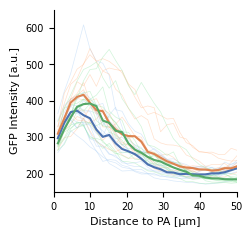

In [2]:
# --- Bin HQNO gradient data ---
file_name = '1_hqno_fluor_gradient_binned_legacy'

# optional: add dictionary of positions to exclude per replicate
# add exclusions=exclusions as input to save_plot_data and plot_all_chambers below
# exclusions = {
#     #'replicate_[nr]': [],
# }

analyzer = (
    HQNOAnalyzer(
        filepath= Path.cwd().parent / 'datafiles' / 'hqno_gradient_microscopy.csv',
            num_x_bins=30,
            num_y_bins=30,
            pixel_to_um=0.065
        )
        .load_data()
        .filter_wt()
        .convert_to_um()
        .define_binning()
    )

df_data = analyzer.export_data(Path.cwd() / 'data' / (file_name + '.csv')) 

# --- Generate figure ---
final_width_in = 6 / 2.54
final_height_in = 6 / 2.54
font_size = 8
plt.rcParams.update({
    'font.size': font_size,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

pos_colors = sns.color_palette("pastel", n_colors=len(df_data['replicate'].unique()))
med_colors = sns.color_palette("deep", n_colors=len(df_data['replicate'].unique()))


fig, ax = plt.subplots(figsize=(final_width_in, final_height_in))

# Plot all individual chamber lines
sns.lineplot(
    data=df_data,
    x='y_um',
    y='median_intensity',
    hue='replicate',
    palette=pos_colors,
    estimator=None,
    units='pos',
    lw=0.5,
    alpha=0.4,
    legend=False,
    ax=ax
)

# Plot median over chambers per replicate
df_median = df_data.groupby(['replicate','y_um'])['median_intensity'].median().reset_index()
sns.lineplot(
    data=df_median,
    x='y_um',
    y='median_intensity',
    hue='replicate',
    lw=1.5,
    ax=ax,
    legend=False,
    palette=med_colors
)

ax.set_xlabel('Distance to PA [µm]', fontsize=font_size)
ax.set_ylabel('GFP Intensity [a.u.]', fontsize=font_size)
ax.tick_params(labelsize=font_size-1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(0, 50)
ax.set_ylim(150,650)

plt.savefig(Path.cwd() / 'figures' / (file_name + '.pdf'), dpi=300, transparent=True)

In [3]:
df_median['replicate'].unique()

array(['replicate_4', 'replicate_5', 'replicate_7'], dtype=object)